In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# libraries for data manipulation and exploration
import pandas as pd
import numpy as np

# for text processing
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
path='/content/drive/MyDrive/'

In [ ]:
# reading the dataset
file_path = path + 'data.csv'
data = pd.read_csv(file_path)

In [ ]:
data.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


In [ ]:
# checking the dimension of dataset
data.shape

(4009, 4)

In [ ]:
# checking if there is any null value
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   URLs      4009 non-null   object
 1   Headline  4009 non-null   object
 2   Body      3988 non-null   object
 3   Label     4009 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 125.4+ KB


In [ ]:
# dropping rows where there is any null value
data.dropna(inplace=True, axis=0)

# taking only the name of website from the URLs
pattern = 'https?://([\w.]+)/'
data['Website'] = data.URLs.str.extract(pattern)
data.drop('URLs', axis=1, inplace=True)

<ipython-input-10-7eadc4d25128>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label',


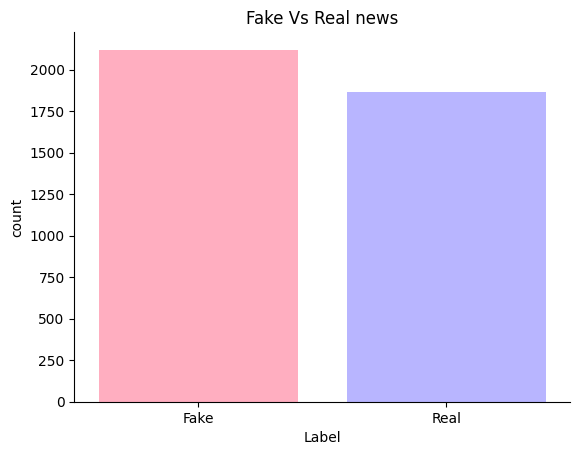

In [ ]:
# making a bar plot to count the frequency of
# fake and real news
sns.countplot(x='Label',
              data=data,
              palette=['#ffaec0', '#b8b5ff'],
              saturation=1)
sns.despine()
plt.xticks([0,1], ['Fake', 'Real'])
plt.title('Fake Vs Real news');

In [ ]:
fake_news_count = data[data.Label == 0]['Website'].value_counts()
real_news_count = data[data.Label == 1]['Website'].value_counts()

In [ ]:
fdf = pd.DataFrame({
    'Web':fake_news_count.index,
    'Fake':fake_news_count.values
})

rdf = pd.DataFrame({
    'Web':real_news_count.index,
    'Real':real_news_count.values
})

In [ ]:
rf_count = pd.merge(rdf, fdf, on='Web', how='outer').fillna(0)
rf_count['Real'] = rf_count['Real'].astype(int)
rf_count['Fake'] = rf_count['Fake'].astype(int)
rf_count

,Web,Real,Fake
0,abcnews.go.com,57,0
1,beforeitsnews.com,0,1681
2,bleacherreport.com,8,0
3,clarivate.com,3,0
4,cnn.it,1,0
5,dailybuzzlive.com,0,99
6,edition.cnn.com,15,0
7,inhealth.cnn.com,14,0
8,money.cnn.com,49,0
9,reuters.com,1,0


<ipython-input-14-558c64a5a185>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=real_news_count[:5].index, x=real_news_count[:5].values,


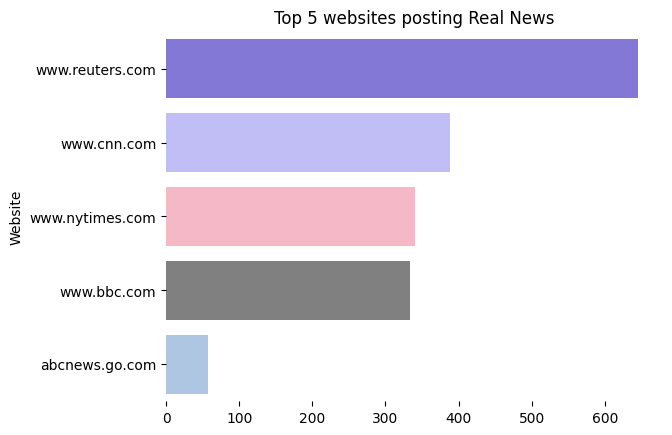

In [ ]:
sns.barplot(y=real_news_count[:5].index, x=real_news_count[:5].values,
            palette=['#7868e6', '#b8b5ff', '#ffaec0', 'grey', '#a7c5eb'])
sns.despine(bottom=True, left=True)
plt.title('Top 5 websites posting Real News');

<ipython-input-16-9325c28a7740>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=fake_news_count.index, x=fake_news_count.values,


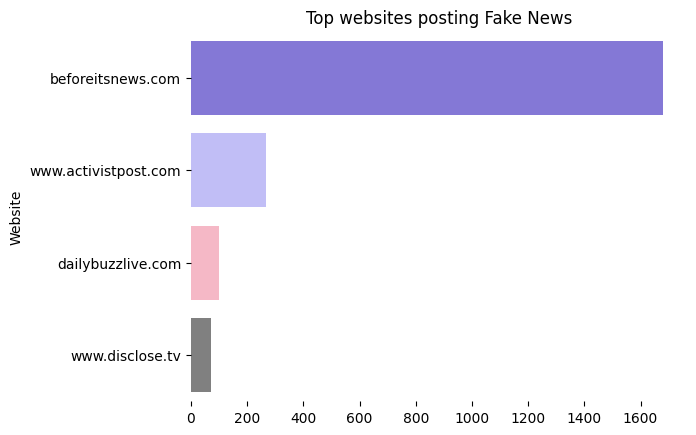

In [ ]:
sns.barplot(y=fake_news_count.index, x=fake_news_count.values,
            palette=['#7868e6', '#b8b5ff', '#ffaec0', 'grey'])
sns.despine(bottom=True, left=True)
plt.title('Top websites posting Fake News');

In [ ]:
# download stopwords
import nltk
nltk.download("stopwords")
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
lm = WordNetLemmatizer()
def clean_text(column):
    corpus = []
    for value in column:
        # convert each word into lower case
        value = value.lower()
        # take only alphabets
        value = re.sub('[^a-z]', ' ', value)
        value = value.split()
        # lemmatizing those words which are not stop words
        value = [lm.lemmatize(word) for word in value\
                 if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(value))
    return corpus

# taking both headline and body of news into a single column
data['Text'] = data['Headline'] + ' ' + data['Body']
data['Text'] = clean_text(data.Text)

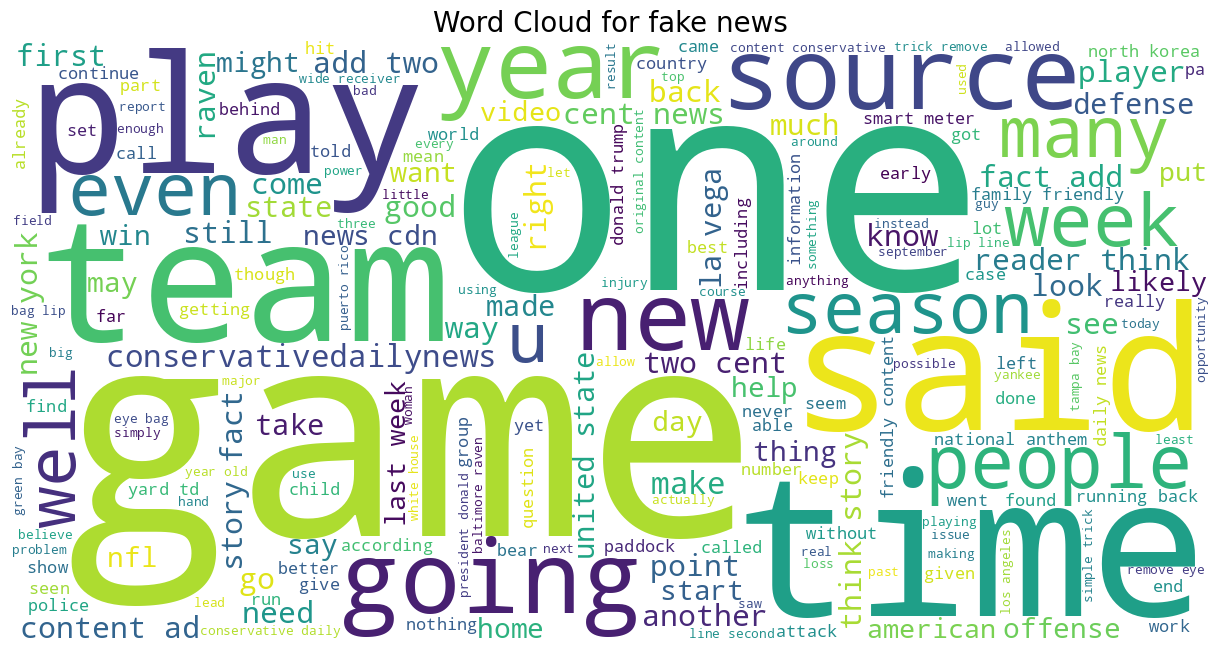

In [ ]:
from wordcloud import WordCloud, STOPWORDS
sw = set(STOPWORDS)

fake_news = data[data.Label == 0]
real_news = data[data.Label == 1]

# wordcloud for fake news
fake_wc = WordCloud(width = 1200, height = 600,
                    background_color ='white',
                    stopwords = sw,
                    min_font_size = 10).generate(' '.join(fake_news.Text))

# plot the WordCloud image
plt.figure(figsize = (12, 6), facecolor = None)
plt.imshow(fake_wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud for fake news', fontsize=20);

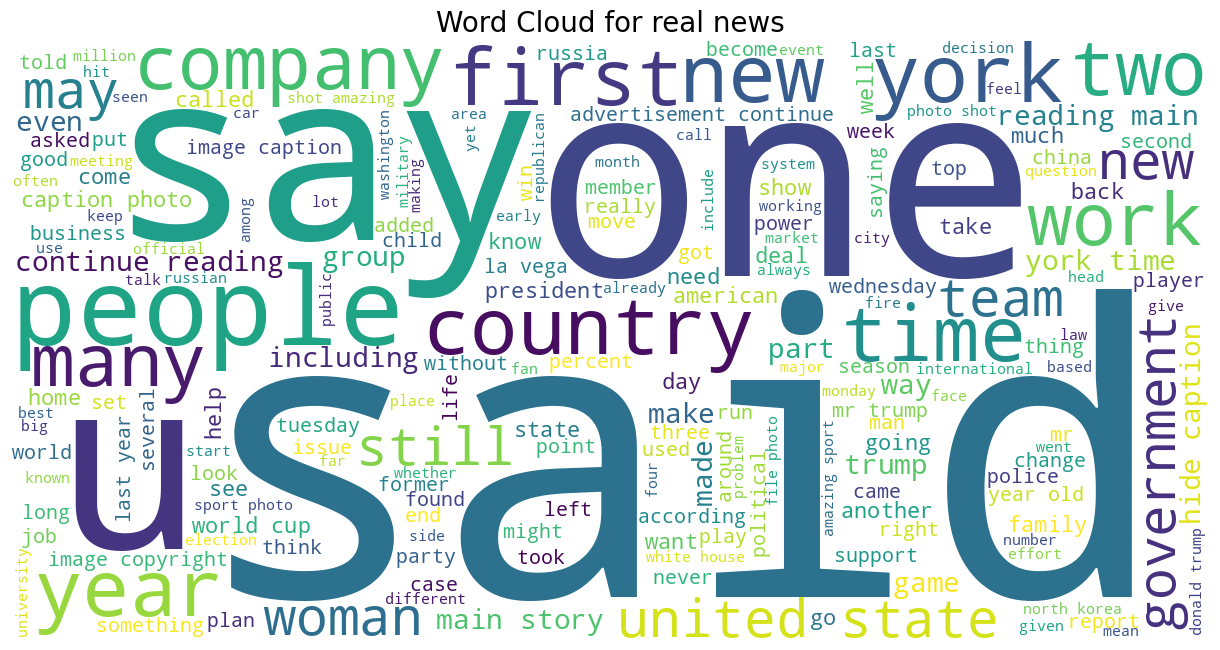

In [ ]:
# wordcloud for real news
real_wc = WordCloud(width = 1200, height = 600,
                    background_color ='white',
                    stopwords = sw,
                    min_font_size = 10).generate(' '.join(real_news.Text))

# plot the WordCloud image
plt.figure(figsize = (12, 6), facecolor = None)
plt.imshow(real_wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud for real news', fontsize=20);

In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# one hot representation of words
oh_repr = [one_hot(words, 5000) for words in data.Text]

In [ ]:
# list to store length of words in each news
len_list = []
for w in data.Text:
    w = w.split()
    len_list.append(len(w))

print('Summary of word length :')
pd.Series(len_list).describe()

Summary of word length :


,0
count,3988.000000
mean,289.271063
std,289.423529
min,10.000000
25%,65.000000
50%,217.000000
75%,419.000000
max,3171.000000


In [ ]:
# taking sentences length as 400
sent_length = 400
# padding
embedded_doc = pad_sequences(oh_repr, padding='pre', maxlen=sent_length)
embedded_doc[:5]

array([[1866, 2086, 2588, ..., 2090, 2299, 1672],
       [   0,    0,    0, ..., 2277, 1003, 4190],
       [1862, 1849, 2563, ..., 2733, 1542, 3661],
       [   0,    0,    0, ..., 1908, 4295, 3873],
       [   0,    0,    0, ..., 4660, 1670, 1705]], dtype=int32)

In [ ]:
# initializing model
model = Sequential()
# adding embedding layer
model.add(Embedding(5000, 100, input_length=sent_length))
model.add(LSTM(150))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.metrics import Precision, Recall
# Define the input layer
input_layer = Input(shape=(sent_length,))  # Specify the input shape

# Add the embedding layer
embedding_layer = Embedding(5000, 100, input_length=sent_length)(input_layer)

# Add the Bidirectional LSTM layer
bilstm_layer = Bidirectional(LSTM(150))(embedding_layer)

# Add the dense output layer
output_layer = Dense(1, activation='sigmoid')(bilstm_layer)

# Define the functional model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', Precision(name="Precision"), Recall(name="Recall")])

# Display the model summary
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_8 (Embedding)              │ (None, 400, 100)            │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 300)                 │         301,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             301 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 801,501 (3.06 MB)

 Trainable params: 801,501 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split
x = np.array(embedded_doc)
y = data.Label

# splitting the dataset into train and test
train_x, test_x, train_y, test_y = train_test_split(x, y,
                                                    test_size=0.25, random_state=3)

In [ ]:
# fitting the model
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10, batch_size=64)

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - Precision: 0.7192 - Recall: 0.4835 - acc: 0.7018 - loss: 0.5854 - val_Precision: 0.9113 - val_Recall: 0.9784 - val_acc: 0.9458 - val_loss: 0.1529
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - Precision: 0.9559 - Recall: 0.9946 - acc: 0.9760 - loss: 0.0882 - val_Precision: 0.9719 - val_Recall: 0.9740 - val_acc: 0.9749 - val_loss: 0.0898
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - Precision: 0.9911 - Recall: 0.9928 - acc: 0.9925 - loss: 0.0339 - val_Precision: 0.9540 - val_Recall: 0.9870 - val_acc: 0.9719 - val_loss: 0.0906
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - Precision: 0.9955 - Recall: 0.9977 - acc: 0.9968 - loss: 0.0109 - val_Precision: 0.9722 - val_Recall: 0.9827 - val_acc: 0.9789 - val_loss: 0.0755
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - Precision: 1.0000 - Recall: 1.0000 - acc: 1.0000 - loss: 0.0019 - val_Precision: 0.9680 - val_Recall: 0.9827 - val_acc: 0.9769 - val_loss: 0.0963
Epoch

In [ ]:
import numpy as np

# پیش‌بینی احتمالات
pred_probs = model.predict(test_x)

# تبدیل احتمالات به کلاس‌ها
pred = (pred_probs > 0.5).astype("int32")


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


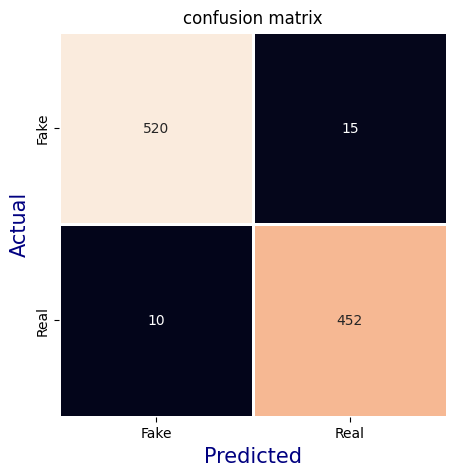

In [ ]:
# plotting graph for confusion matrix

cm = confusion_matrix(test_y, pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='', cbar=False, linewidths=2,
            xticklabels = ['Fake','Real'], yticklabels = ['Fake','Real'])
plt.title('confusion matrix')
plt.xlabel('Predicted', color='navy', fontsize=15)
plt.ylabel('Actual', color='navy', fontsize=15);

In [ ]:
# accuracy of the model we built
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(test_y, pred)
precision = precision_score(test_y, pred)
recall = recall_score(test_y, pred)
f1 = f1_score(test_y, pred)

print("Model Accuracy : ", accuracy)
print("Model Precision: ", precision)
print("Model Recall   : ", recall)
print("Model F1 Score : ", f1)

Model Accuracy :  0.9749247743229689
Model Precision:  0.9678800856531049
Model Recall   :  0.9783549783549783
Model F1 Score :  0.9730893433799784


So, we built a LSTM model with 97% accuracy which is quit amazing. We can try other parameters in order to increase the accuracy.